In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from environments import OctorotorEnvSelector
from systems.pid_agent import PIDAgent
from multirotor.helpers import DataLog
from systems.long_blending import softmax
from parameters import pid_params as p_p
from stable_baselines3 import PPO

In [2]:
def get_tte(initial_pos: tuple, waypoints: np.ndarray, x: np.ndarray, y:np.ndarray, z:np.ndarray) -> np.ndarray:
        """
        Calculates the trajectory tracking error. 
        The distance between the current point and the vector between previous and next wp. Uses ||v1 x v2|| / ||v1||.

        Parameters
        ----------
        initial_pos : tuple  
            the initial position of the UAV.
        waypoints : np.ndarray 
            the reference positions at each point in time.
        x : np.ndarray 
            the x positions of the UAV.
        y : np.ndarray 
            the y positions of the UAV.
        z : np.ndarray
            the z positions of the UAV.

        Returns
        -------
        np.ndarray 
            the trajectory tracking error at each point in time.
        """
        ttes = []
        prev = initial_pos
        for i, waypoint in enumerate(waypoints):
            if i > 0 and not np.array_equal(waypoints[i-1], waypoints[i]):
                prev = waypoints[i-1]

            v1 = waypoint - prev
            v2 = np.array([x[i],y[i],z[i]]) - prev
            tte = np.linalg.norm(np.cross(v1, v2)) / (np.linalg.norm(v1) + 1e-6)
            ttes.append(tte)
                
        return np.array(ttes)

def toc(tte: np.ndarray):
    corridor = 2
    return len(tte[tte > corridor]) / 2

def completed_mission(waypoints: np.ndarray, x: np.ndarray, y: np.ndarray, z: np.ndarray, radius: float = 0.65):
        for waypoint in waypoints:
            reached_waypoint = False

            for position in zip(x,y,z):
                dist = np.linalg.norm(waypoint - position)

                if dist <= radius:
                    reached_waypoint = True
                    break

            if not reached_waypoint:
                return False
            
        return True

In [3]:
env_selector = OctorotorEnvSelector()

pid_params = {'steps_u':50, 'scaling_factor':0, 'window_distance':1000, 'pid_parameters':p_p()}
pid_agent = PIDAgent()


lstm_agent = PPO.load('./saved_models/higher_actions_noZ/96') 
lstm_params = {'steps_u':50, 'scaling_factor':1, 'window_distance':23, 'pid_parameters':p_p()}


lstm_params['steps_u'] = 50
lstm_params['bounding_rect_length']=1000

In [4]:
all_agents = [pid_agent, lstm_agent]
all_params = [pid_params, lstm_params]
types = ["default", "lstm"]
names = ['PID', 'RL']

In [5]:
nasa_wp = np.asarray([ # defines a real trajectory shown in a NASA paper
    [164.0146725649829, -0.019177722744643688, 30],
    [165.6418055187678, 111.5351051245816, 30],
    [127.3337449710234, 165.73576059611514, 30],
    [-187.28170707810204, 170.33217775914818, 40],
    [-192.03130502498243, 106.30660058604553, 40],
    [115.89920266153058, 100.8644210617058, 30],
    [114.81859536317643, 26.80923518165946, 30],
    [-21.459931490011513, 32.60508110653609, 30]
])

In [6]:
traj_len = 500 # trajectory seems to be around 500 seconds to complete
all_masses = [8.66, 9.66, 10.66, 11.66, 12.66, 13.66, 14.66, 15.66]

In [7]:
def sample_wind():
    wind_vec = np.random.uniform(-10,10,2)
    mag = np.linalg.norm(wind_vec)
    
    if mag > 10:
        wind_vec = wind_vec * (10/mag)

    return wind_vec

In [8]:
# Evaluates all saved agents with their params on a wind range
def wind_injection(agents, params, types, names, all_masses):
    results = pd.DataFrame(columns=['Agent', 'Mass', 'Total TTE', 'Mean TTE', 'Completed Mission', 'Reward', 'Time Outside Corridor'])
    for mass in tqdm(all_masses):
        for agent, param, env_type, name in tqdm(zip(agents, params, types, names), total=len(agents)):
            env = env_selector.get_env(env_type, param, [(0,0),(0,0),(0,0)], nasa_wp, has_turbulence=True, start_alt=30)
            env.wp_options = [nasa_wp]
            env.base_env.fault_type = None
            env.base_env.vehicle.mass = mass
            done = False
            state = env.reset()
            state = np.array(state, dtype=np.float32)
            log = DataLog(env.base_env.vehicle, other_vars=('reward','next_wp'))
            index = 0
            while not done:
                action = agent.predict(state, deterministic=True)[0] 
                state, reward, done, info = env.step(action)
                state = np.array(state, dtype=np.float32)
                log.log(reward=reward, next_wp=env.base_env.next_waypt)
                index += 1
            
            log.done_logging()
            traj_err = get_tte(log.next_wp[0], log.next_wp, log.x, log.y, log.z)
            new_result = {
                'Agent': name,
                'Mass': mass,
                'Mean TTE': np.mean(traj_err),
                'Total TTE': np.sum(traj_err),
                'Completed Mission': completed_mission(nasa_wp, log.x, log.y, log.z, radius=2),
                'Reward': np.sum(log.reward),
                'Time Outside Corridor': toc(traj_err)
            }
            results = pd.concat([results, pd.DataFrame([new_result])], ignore_index=True)

    return results

In [9]:
sample_wind()

array([-7.42613236,  6.55308408])

In [10]:
results = wind_injection(all_agents, all_params, types, names, all_masses)

  0%|          | 0/8 [00:00<?, ?it/s]/tmp/ipykernel_4158833/1841711471.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([new_result])], ignore_index=True)
100%|██████████| 8/8 [08:10<00:00, 61.26s/it]


In [11]:
results.to_csv('./data/mass_shift.csv')

In [12]:
results = pd.read_csv('./data/mass_shift.csv')

In [13]:
results

,Unnamed: 0,Agent,Changes,Total TTE,Mean TTE,Completed Mission,Reward,Time Outside Corridor,Mass
0,0,PID,NaN,741.957818,2.060994,True,12307.71600,56.0,8.66
1,1,RL,NaN,418.714766,0.888991,True,-610.03815,0.0,8.66
2,2,PID,NaN,638.058577,1.828248,True,13531.63000,53.0,9.66
3,3,RL,NaN,235.333213,0.506093,True,1481.53220,0.0,9.66
4,4,PID,NaN,583.941654,1.712439,True,14177.34100,52.0,10.66
5,5,RL,NaN,152.201329,0.330155,True,2474.26420,0.0,10.66
6,6,PID,NaN,606.702965,1.794979,True,13798.41600,49.5,11.66
7,7,RL,NaN,258.387349,0.559280,True,1226.25840,0.0,11.66
8,8,PID,NaN,674.090307,1.994350,True,12980.40800,49.5,12.66
9,9,RL,NaN,434.602971,0.936644,True,-779.25170,0.0,12.66


## Plots

Text(0.5, 0, 'UAV Mass (kg)')

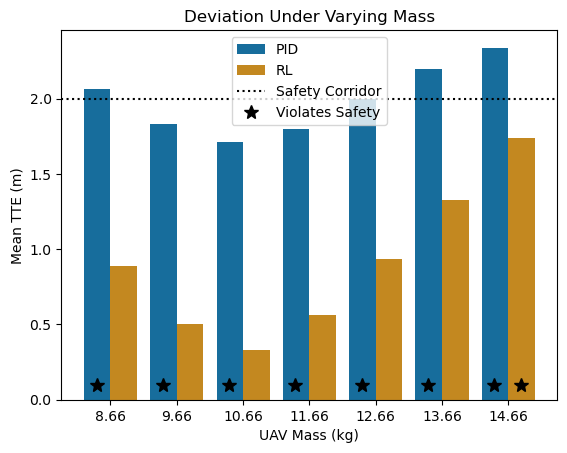

In [58]:
import seaborn as sns

plt.title("Deviation Under Varying Mass")
# filtered_results = results[results['Agent'] == 'DI-RL']
filtered_results = results[results['Mass'] < 15]
ax = sns.barplot(x=filtered_results['Mass'], y=filtered_results['Mean TTE'], hue=filtered_results['Agent'], palette='colorblind')
plt.axhline(y=2, label='Safety Corridor', color='black', linestyle=':')
ax.plot(-0.2, 0.1, "*", markersize=10, color="black", label='Violates Safety')
ax.plot(0.79, 0.1, "*", markersize=10, color="black")
ax.plot(1.79, 0.1, "*", markersize=10, color="black")
ax.plot(2.79, 0.1, "*", markersize=10, color="black")
ax.plot(3.79, 0.1, "*", markersize=10, color="black")
ax.plot(4.79, 0.1, "*", markersize=10, color="black")
ax.plot(5.79, 0.1, "*", markersize=10, color="black")
ax.plot(6.19, 0.1, "*", markersize=10, color="black")
plt.legend()
plt.ylabel("Mean TTE (m)")
plt.xlabel("UAV Mass (kg)")